# NWA suntans: mooring like data

see [description](https://github.com/TIDE-ITRH/tide-suntans-nws) and relevant paper: [Rayson et al. 2021](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JC017570)

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import gsw

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43067,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:47754,Total threads: 7
Dashboard: http://127.0.0.1:42068/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:41617,


---
## load data

In [2]:
ds, grd = nwa.load_surf()

In [3]:
mo = nwa.load_moorings()
mo = mo.resample(time="1H").interpolate()
# add potential density
mo["rho"] = gsw.pot_rho_t_exact(mo.salt, mo.temp, mo.z_r, 0.)
# compute a mask in the vertical
vmask = abs(mo["uc"].isel(time=10, drop=True)).fillna(0)
vmask = vmask.where(vmask==0, other=1)
mo = mo.assign_coords(h=(mo.dz*vmask).sum("Nk"))

In [4]:
# low pass filter
from oceans.filters import lanc
w_lanczos40 = lanc(96 + 1 + 96, 1.0 / 40)

weights = xr.DataArray(w_lanczos40, dims=["window"])

#ds = ds.isel(Nc=slice(0,100))
low = xr.merge([mo[v]
       .rolling(time=w_lanczos40.size, center=True)
       .construct(time="window")
       .dot(weights)
       .rename(v)
            for v in ["eta", "temp", "salt", "rho", "uc", "vc", "w", "kappa_t"]
]
)
#low = low.assign_coords(**mo.coords)

In [6]:
# low["eta"].plot(hue="Nc") # -.3 to .2

---

## plotting

Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


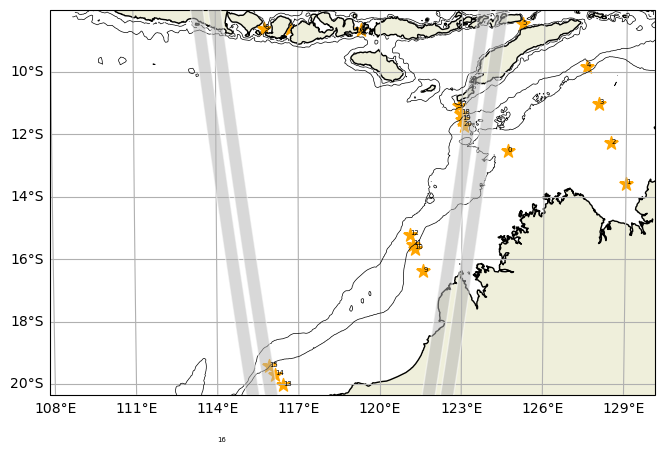

In [7]:
fig, ax = nwa.map_init("large", bathy=(grd, ds))
#_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap='RdBu')
for p in mo.Nc:
    m = mo.sel(Nc=p)
    lon, lat = m.lonv, m.latv
    ax.scatter(lon, lat, s=100, marker="*", c="orange", transform=crs)
    ax.text(lon, lat, f"{int(m.Nc)}", size=5, transform=crs, zorder=20)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


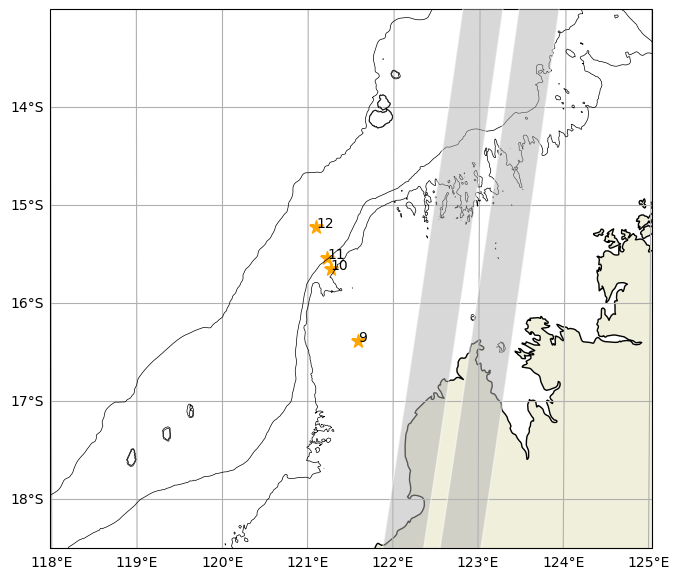

In [8]:
fig, ax = nwa.map_init("central", bathy=(grd, ds))

_mo = nwa.zoom(mo, nwa.bounds["central"], x="lonv", y="latv")

for p in _mo.Nc:
    m = mo.sel(Nc=p)
    lon, lat = m.lonv, m.latv
    ax.scatter(lon, lat, s=100, marker="*", c="orange", transform=crs)
    ax.text(lon, lat, f"{int(m.Nc)}", size=10, transform=crs, zorder=20)

---

## look at potential density

In [34]:
def add_potential_density(mo):
    mo["rho_bar"] = (mo.rho * mo.dz).sum("Nk") / mo.h
    mo["phi"] = ( 9.81*mo.z_r*(mo.rho-mo.rho_bar) * mo.dz).sum("Nk") / mo.h
    return mo

In [35]:
mo = add_potential_density(mo)

low = add_potential_density(low)
# need to mask first&last times
mask = (low.rho_bar>0)
low["rho_bar"] = low["rho_bar"].where(mask)
low["phi"] = low["phi"].where(mask)

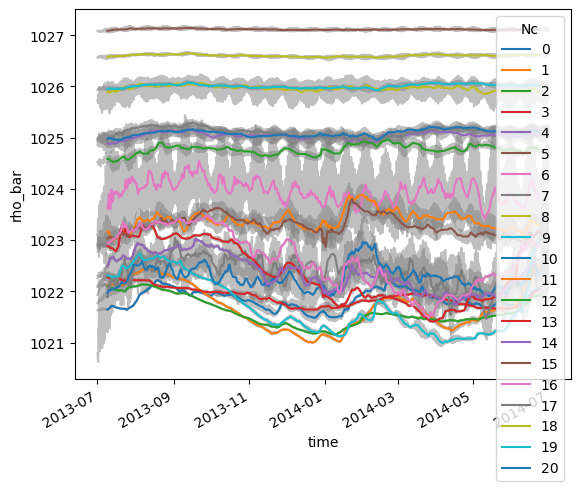

In [37]:
mo["rho_bar"].plot(x="time", hue="Nc", color="0.5", alpha=0.5)
low["rho_bar"].plot(x="time", hue="Nc");

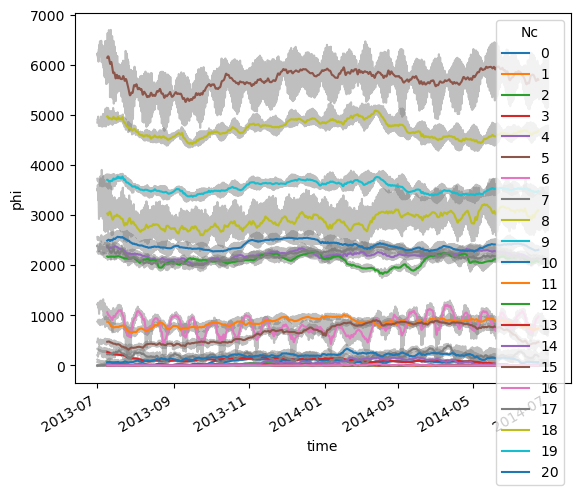

In [38]:
mo["phi"].plot(x="time", hue="Nc", color="0.5", alpha=0.5);
low["phi"].plot(x="time", hue="Nc");

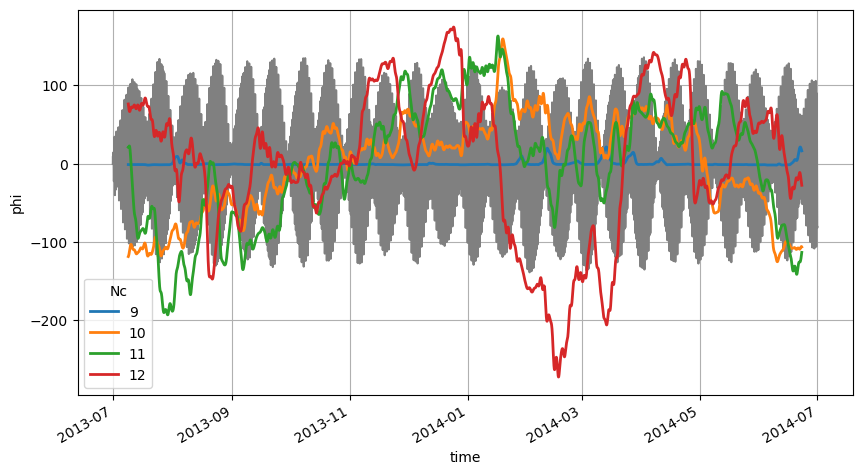

In [55]:
#mo["phi"].plot(x="time", hue="Nc", color="0.5", alpha=0.5);
fig, ax = plt.subplots(1,1, figsize=(10,5))
(mo["eta"]*50).sel(Nc=9).plot(ax=ax, x="time", color="0.5")
(low["phi"]-low["phi"].mean("time")).sel(Nc=[9,10,11,12]).plot(ax=ax, x="time", hue="Nc", lw=2);
ax.grid()

---
## plot time series of all relevant variables

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


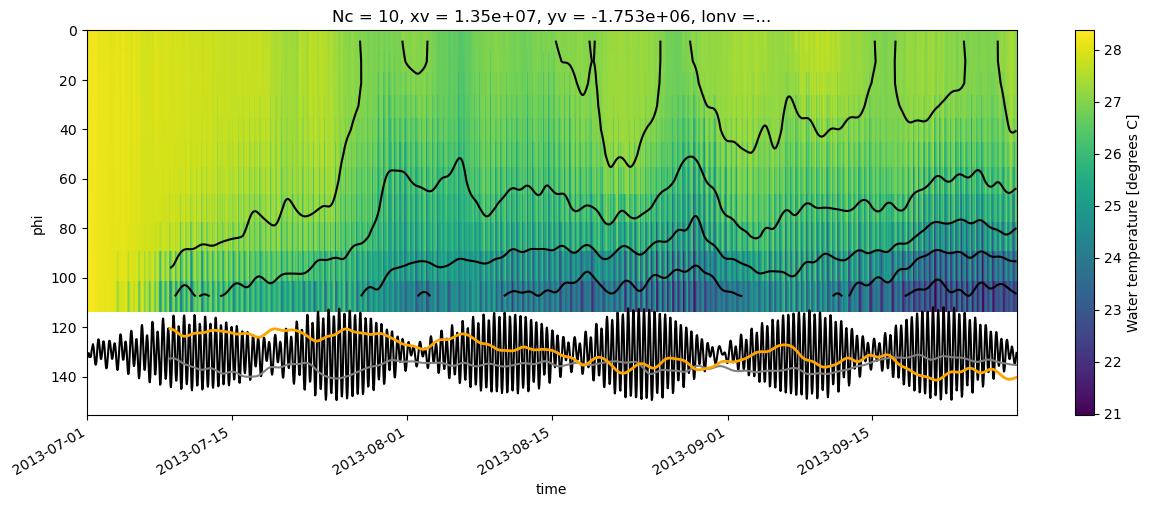

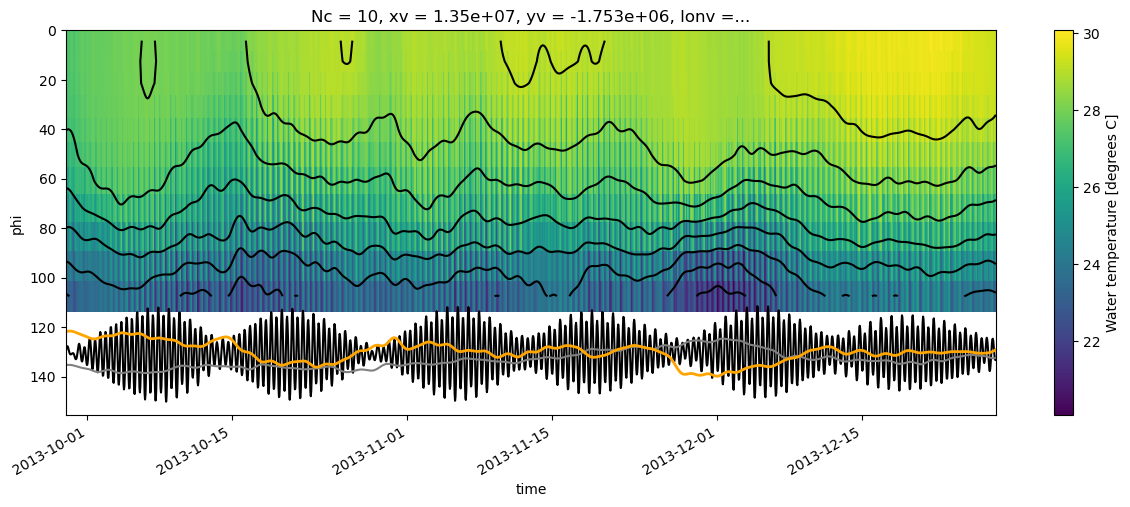

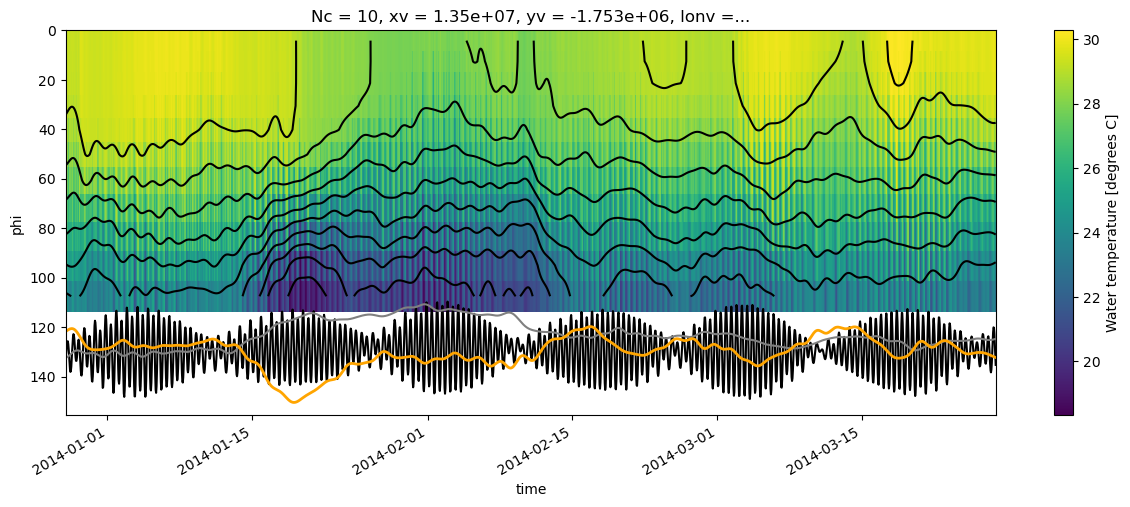

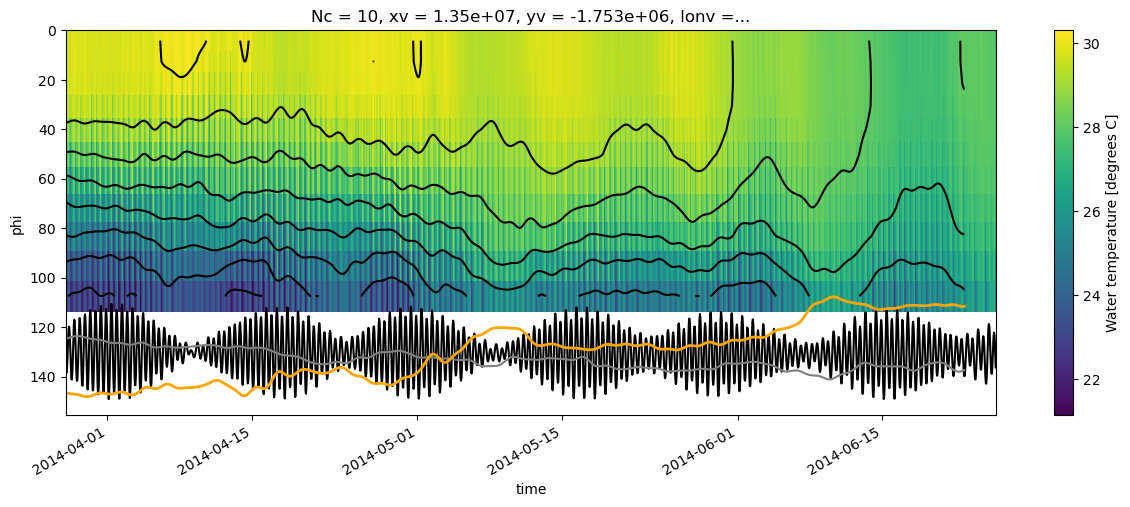

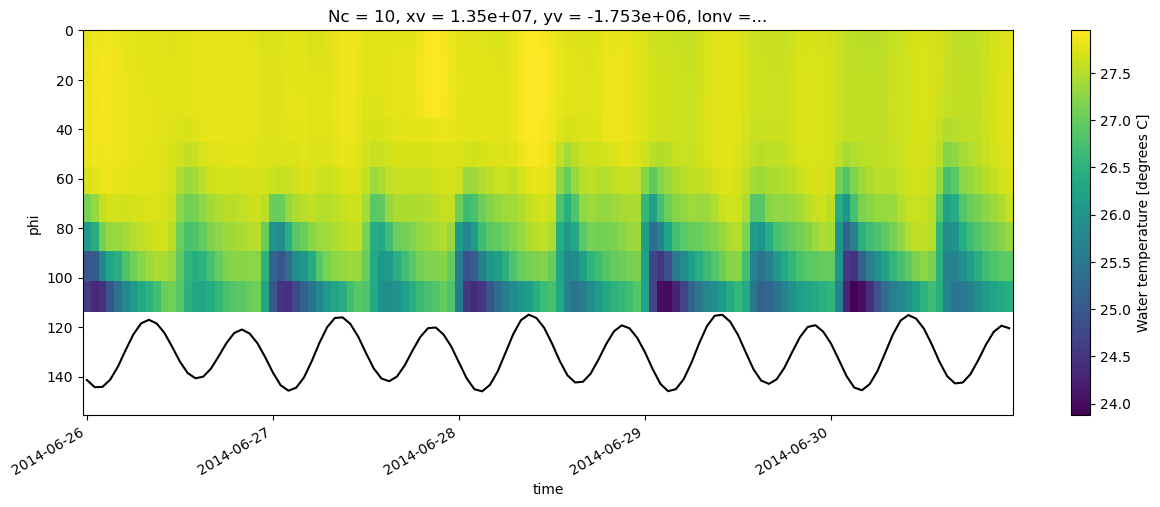

In [52]:
nc=10
t = mo.time[0]
dt = pd.Timedelta("90D")

#t = t+2*dt # dev

while t<mo.time[-1]:

    _mo = mo.where( (mo.time>=t) & (mo.time<t+dt), drop=True)
    _low = low.where( (low.time>=t) & (low.time<t+dt), drop=True)

    fig, ax = plt.subplots(1,1, figsize=(15,5))
    _mo.temp.sel(Nc=nc, Nk=slice(0,13)).plot(x="time", y="z_r", ax=ax)
    _low.temp.sel(Nc=nc, Nk=slice(0,13)).plot.contour(x="time", y="z_r", ax=ax, levels=np.arange(15,35,1), colors="k")
    ax.invert_yaxis()

    (_mo.eta*10+130).sel(Nc=nc).plot(ax=ax, color="k")
    (_low.eta*100+130).sel(Nc=nc).plot(ax=ax, color="0.5")
    ((_low.phi-_low.phi.mean("time"))/5+130).sel(Nc=nc).plot(ax=ax, color="orange", lw=2)

    t+=dt

---

In [41]:
cluster.close()